In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [18]:
df = pd.read_csv('CAR DETAILS FROM CAR DEKHO.csv')


## Data Exploration

In [19]:
print("Dataset Shape:", df.shape)

print("Dataset Columns:", df.columns)

print("Dataset Info:")
df.info()

print("Dataset Description:")
print(df.describe())

print("Null Values:")
print(df.isnull().sum())


Dataset Shape: (4340, 8)
Dataset Columns: Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner'],
      dtype='object')
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB
Dataset Description:
              year  selling_price      km_driven
count  4340.000000   4.340000e+03    4340.000000
mean   2013.090783   5.041273e+05   66215.777419
std       4.215344   5.785487e+05   46644.102194
min    1

## Data Visualization

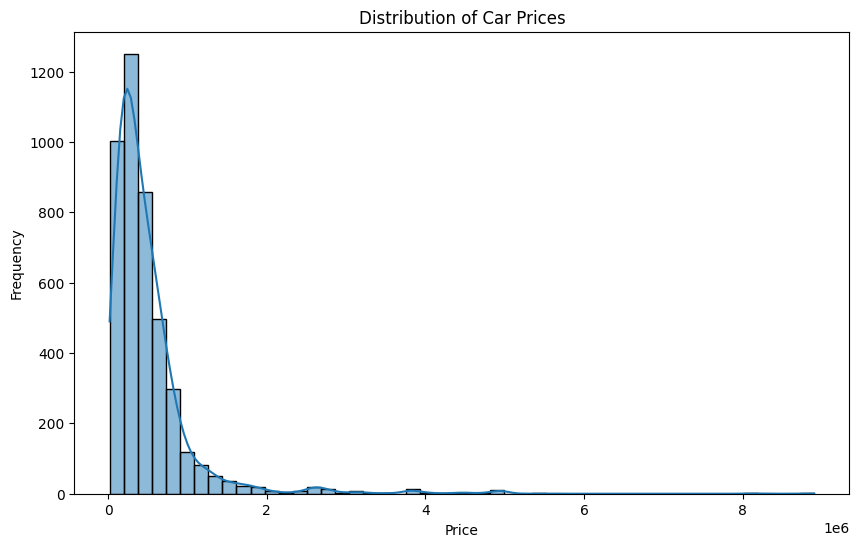

In [20]:

plt.figure(figsize=(10, 6))
sns.histplot(df['selling_price'], bins=50, kde=True)
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


## Feature Engineering

In [21]:

df['brand'] = df['name'].apply(lambda x: x.split(' ')[0])

categorical_features = ['fuel', 'seller_type', 'transmission', 'owner', 'brand']


## Data Preprocessing

In [22]:

numerical_features = ['year', 'km_driven']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


## Converting Categorical Values to Numerical

In [23]:
label_encoder = {}
for column in ['name', 'fuel', 'seller_type', 'transmission', 'owner', 'brand']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoder[column] = le


## Outlier Detection and Handling

In [24]:

def remove_outliers(df):
    df_cleaned = df.copy()
    for column in df_cleaned.select_dtypes(include=[np.number]).columns:
        Q1 = df_cleaned[column].quantile(0.25)
        Q3 = df_cleaned[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_cleaned = df_cleaned[(df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound)]
    return df_cleaned

df_cleaned = remove_outliers(df)


## Model Building

In [25]:

X = df.drop(columns=['name', 'selling_price'])
y = df['selling_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}


for model_name, model in models.items():

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    print(f"{model_name} Cross-Validation MAE: {-scores.mean()}")

    # Train the model
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    print(f"\n{model_name} Model Evaluation:")
    print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
    print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
    print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R^2 Score:", r2_score(y_test, y_pred))


RandomForest Cross-Validation MAE: 127535.378440335

RandomForest Model Evaluation:
Mean Absolute Error: 115421.02937638028
Mean Squared Error: 78856818919.70024
Root Mean Squared Error: 280814.5632258061
R^2 Score: 0.741597322821098
GradientBoosting Cross-Validation MAE: 144745.44008595034

GradientBoosting Model Evaluation:
Mean Absolute Error: 145154.54599228888
Mean Squared Error: 95774493724.27722
Root Mean Squared Error: 309474.54454975325
R^2 Score: 0.6861604877948676


## Model Evaluation

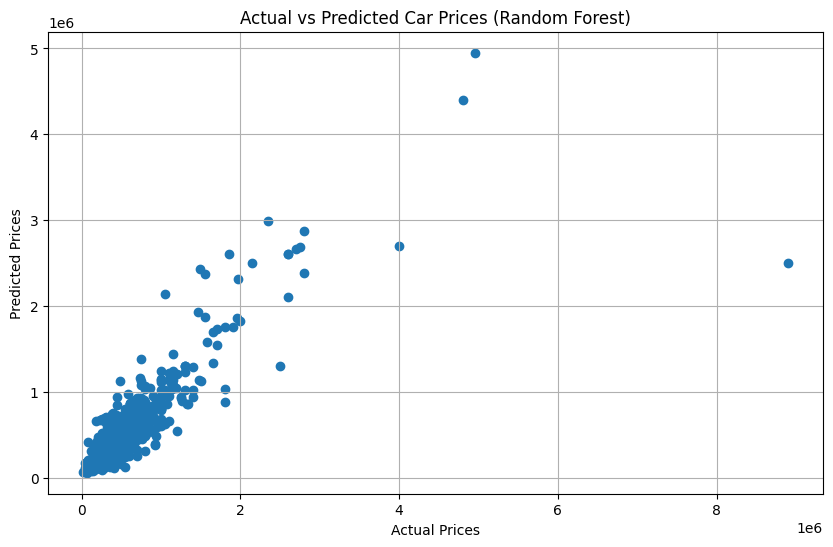

In [26]:
# Plotting predictions vs actual values for the best model (Random Forest)
best_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', models['RandomForest'])
])

best_model_pipeline.fit(X_train, y_train)
y_pred = best_model_pipeline.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Car Prices (Random Forest)')
plt.grid(True)
plt.show()


# Check on inputs:

In [27]:
# Function to use the trained model on user inputs
def predict_car_price(year, km_driven, fuel, seller_type, transmission, owner, brand):
    # Encode categorical inputs
    fuel = label_encoder['fuel'].transform([fuel])[0]
    seller_type = label_encoder['seller_type'].transform([seller_type])[0]
    transmission = label_encoder['transmission'].transform([transmission])[0]
    owner = label_encoder['owner'].transform([owner])[0]
    brand = label_encoder['brand'].transform([brand])[0]

    # Create a dataframe for the input
    input_df = pd.DataFrame({
        'year': [year],
        'km_driven': [km_driven],
        'fuel': [fuel],
        'seller_type': [seller_type],
        'transmission': [transmission],
        'owner': [owner],
        'brand': [brand]
    })

    # Predict the price
    predicted_price = pipeline.predict(input_df)
    return predicted_price[0]

# Example user input
user_input = {
    'year': 2015,
    'km_driven': 50000,
    'fuel': 'Petrol',
    'seller_type': 'Individual',
    'transmission': 'Manual',
    'owner': 'First Owner',
    'brand': 'Maruti'
}

predicted_price = predict_car_price(
    user_input['year'],
    user_input['km_driven'],
    user_input['fuel'],
    user_input['seller_type'],
    user_input['transmission'],
    user_input['owner'],
    user_input['brand']
)

print(f"Predicted Car Price: {predicted_price}")

Predicted Car Price: 350761.765549448
